In [716]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

# Считаем конверсию регистрации

## Загрузка данных

In [1569]:
load_dotenv('charts_project.env')

True

In [1570]:
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [1571]:
r = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})

In [1572]:
r.status_code

200

In [1573]:
visits = pd.DataFrame(r.json())

In [1574]:
visits.shape

(263459, 4)

In [1575]:
visits.describe()

,datetime,platform,user_agent,visit_id
count,263459,263459,263459,263459
unique,261204,4,32,146085
top,"Thu, 06 Jul 2023 10:45:50 GMT",web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,64167edd-323a-4ab0-be9b-acd237a1ac30
freq,3,236301,13623,4


In [1576]:
r = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})

In [1577]:
r.status_code

200

In [1578]:
registrations = pd.DataFrame(r.json())

In [1579]:
registrations.head()

,datetime,email,platform,registration_type,user_id
0,"Wed, 01 Mar 2023 07:40:13 GMT",ebyrd@example.org,web,google,2e0f6bb8-b029-4f45-a786-2b53990d37f1
1,"Wed, 01 Mar 2023 13:14:00 GMT",knightgerald@example.org,web,email,f007f97c-9d8b-48b5-af08-119bb8f6d9b6
2,"Wed, 01 Mar 2023 03:05:50 GMT",cherylthompson@example.com,web,apple,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15
3,"Wed, 01 Mar 2023 00:04:47 GMT",halldavid@example.org,web,email,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60
4,"Wed, 01 Mar 2023 18:31:52 GMT",denise86@example.net,web,google,27f875fc-f8ce-4aeb-8722-0ecb283d0760


In [1580]:
registrations.shape

(21836, 5)

In [1581]:
registrations.describe()

,datetime,email,platform,registration_type,user_id
count,21836,21836,21836,21836,21836
unique,21821,20868,3,4,21836
top,"Fri, 23 Jun 2023 13:10:45 GMT",ujones@example.com,android,email,2e0f6bb8-b029-4f45-a786-2b53990d37f1
freq,2,6,10582,8996,1


## Предобработка данных

In [1582]:
# провека на пропуски
visits.isna().sum()

datetime      0
platform      0
user_agent    0
visit_id      0
dtype: int64

In [1583]:
# удаление посещения ботами
bot_visits_mask = visits.user_agent.str.contains(pat='bot', case=False)
visits_clean = visits[~bot_visits_mask]

In [1584]:
#приведение даты к формату дейттайм
visits_clean['datetime'] = pd.to_datetime(visits_clean['datetime'])

/var/folders/w6/n_fcyv095mx312wbmf2httjc0000gn/T/ipykernel_13152/540874277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits_clean['datetime'] = pd.to_datetime(visits_clean['datetime'])


In [1585]:
registrations['datetime'] = pd.to_datetime(registrations['datetime'])

In [1586]:
# удаление дубликатов
visits_clean = visits_clean.sort_values('datetime', ascending=False).drop_duplicates(subset='visit_id')

In [1587]:
visits_clean.shape

(138703, 4)

In [1588]:
visits_clean.duplicated(subset='visit_id').sum()

0

In [1589]:
registrations.isna().sum()

datetime             0
email                0
platform             0
registration_type    0
user_id              0
dtype: int64

In [1590]:
#registrations.duplicated(subset='email').sum()

In [1591]:
#registrations = registrations.sort_values('datetime', ascending=False).drop_duplicates(subset='email')

In [1592]:
#выделние даты из даты+время 
visits_clean['date'] = visits_clean.datetime.dt.floor('d')

In [1593]:
registrations['date'] = registrations.datetime.dt.floor('d')

## Агрегация данных по дате и платформе

In [1594]:
visits_count = visits_clean \
    .groupby(['date', 'platform'], as_index=False) \
    .agg(visits=('visit_id', 'count')) 
    

In [1595]:
registrations_count = registrations \
    .groupby(['date', 'platform'], as_index=False) \
    .agg(registrations=('user_id', 'count'))

In [1596]:
visits_count.head(12)

,date,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31
5,2023-03-02,web,515
6,2023-03-03,android,26
7,2023-03-03,ios,40
8,2023-03-03,web,617
9,2023-03-04,android,94


## Объединение датафреймов по дате и платформе и подсчет конверсии

In [1602]:
conversion = visits_count \
    .merge(registrations_count, how='left', on=['date', 'platform']) \
    .rename(columns={'date': 'date_group'}) \
    .sort_values('date_group') \
    .reset_index(drop=True)

In [1605]:
conversion['conversion'] = conversion.registrations / conversion.visits * 100

In [1606]:
conversion

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.606061
548,2023-08-30,web,1227,34,2.770986
549,2023-08-31,android,57,42,73.684211
550,2023-08-31,ios,50,36,72.000000


## Запись полученных данных

In [1601]:
conversion.to_json('./conversion.json')

# Добавляем рекламные кампании

In [1465]:
ads = pd.read_csv('ads.csv')

In [1466]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          159 non-null    object
 1   utm_source    159 non-null    object
 2   utm_medium    159 non-null    object
 3   utm_campaign  159 non-null    object
 4   cost          159 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 6.3+ KB


In [1467]:
ads.isna().sum()

date            0
utm_source      0
utm_medium      0
utm_campaign    0
cost            0
dtype: int64

In [1468]:
ads.duplicated().sum()

0

In [1469]:
ads['date_group'] = pd.to_datetime(ads.date).dt.floor('D')

In [1470]:
ads_short = ads[['date_group', 'cost', 'utm_campaign']]

In [1471]:
conversion_short = conversion \
    .groupby('date_group', as_index=False) \
    .agg({'visits': 'sum', 'registrations': 'sum'})

In [1472]:
conversion_short.head()

,date_group,visits,registrations
0,2023-03-01,376,87
1,2023-03-02,613,105
2,2023-03-03,683,107
3,2023-03-04,647,158
4,2023-03-05,707,115


In [1473]:
ads_conversion = conversion_short.merge(ads_short, how='left', on='date_group')

In [1474]:
ads_conversion = ads_conversion.fillna({'cost': 0, 'utm_campaign': 'none'})

In [1475]:
ads_conversion.to_json('./ads.json')

In [1476]:
ads_conversion.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,212.0,advanced_algorithms_series
1,2023-03-02,613,105,252.0,advanced_algorithms_series
2,2023-03-03,683,107,202.0,advanced_algorithms_series
3,2023-03-04,647,158,223.0,advanced_algorithms_series
4,2023-03-05,707,115,265.0,advanced_algorithms_series


# Визуализация

In [1477]:
! mkdir ./charts

mkdir: ./charts: File exists


In [1478]:
conversion.head()

,date_group,platform,visits,registrations
0,2023-03-01,android,75,61
1,2023-03-01,ios,22,18
2,2023-03-01,web,279,8
3,2023-03-02,android,67,59
4,2023-03-02,ios,31,23


In [1479]:
conversion_short.head()

,date_group,visits,registrations
0,2023-03-01,376,87
1,2023-03-02,613,105
2,2023-03-03,683,107
3,2023-03-04,647,158
4,2023-03-05,707,115


In [1480]:
conversion_short = conversion[
    (conversion.date_group > '2023-03-05') 
    & (conversion.date_group < '2023-08-28')]

In [1481]:
conversion_short['week'] = conversion_short \
    .date_group.dt.to_period("W") \
    .astype('str').str.split('/') \
    .map(lambda x: x[0])

/var/folders/w6/n_fcyv095mx312wbmf2httjc0000gn/T/ipykernel_13152/23500996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversion_short['week'] = conversion_short \


In [1482]:
conversion_short.week = pd.to_datetime(conversion_short.week).dt.strftime('%m-%d')

/var/folders/w6/n_fcyv095mx312wbmf2httjc0000gn/T/ipykernel_13152/4264113211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversion_short.week = pd.to_datetime(conversion_short.week).dt.strftime('%m-%d')


In [1483]:
conversion_by_week = conversion_short \
    .groupby('week', as_index=False) \
    .agg({'visits': 'sum', 'registrations' : 'sum'})

In [1484]:
conversion_by_week['conversion'] = conversion_by_week['registrations'] / conversion_by_week['visits'] * 100

In [1485]:
conversion_by_week_platform = conversion_short \
    .groupby(['week', 'platform'], as_index=False) \
    .agg({'visits': 'sum', 'registrations' : 'sum'})

In [1486]:
conversion_by_week_platform['conversion'] = conversion_by_week_platform['registrations'] / conversion_by_week_platform['visits'] * 100

In [1487]:
conversion_by_week.head()

,week,visits,registrations,conversion
0,03-06,8615,1179,13.685432
1,03-13,5215,822,15.762224
2,03-20,3950,658,16.658228
3,03-27,4958,843,17.002824
4,04-03,5797,1034,17.836812


/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


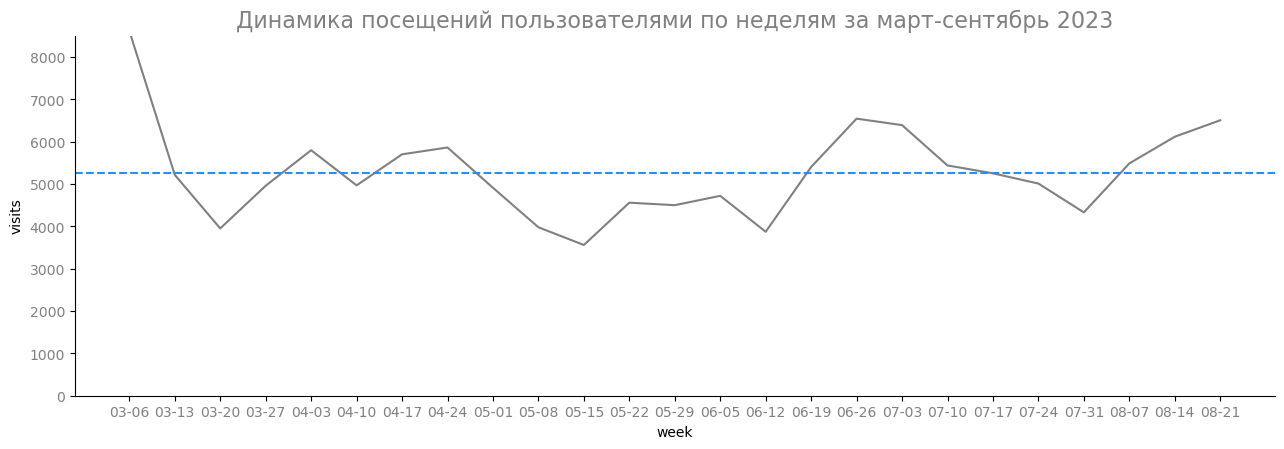

In [1488]:
plt.figure(figsize=(12, 4))
plt.ylim(0, 8500)
plt.subplots_adjust(top=1, bottom=0.1, right=1.1, left=0.1, hspace=0.1, wspace=0.1)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(color='grey')
plt.yticks(color='grey')

plt.title(
    'Динамика посещений пользователями по неделям за март-сентябрь 2023',
    fontdict={'fontsize': 16,
              'color': 'grey'}
)

sns.lineplot(x='week', y='visits', data=conversion_by_week, color='grey')
plt.axhline(y=conversion_by_week.visits.mean(), color='dodgerblue', linestyle='--')


plt.savefig('./charts/visits.png')

/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


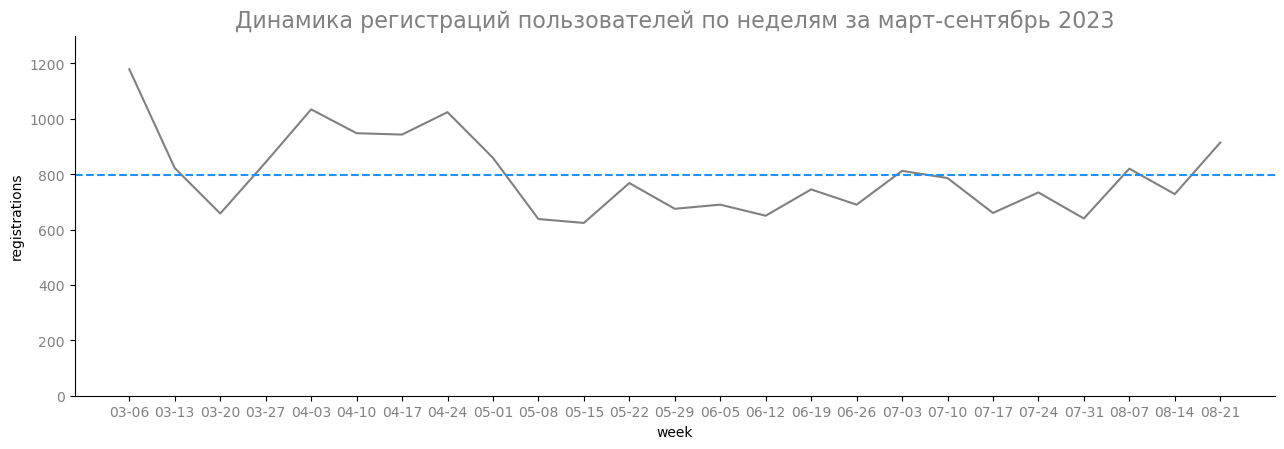

In [1489]:
plt.figure(figsize=(12, 4))
plt.ylim(0, 1300)
plt.subplots_adjust(top=1, bottom=0.1, right=1.1, left=0.1, hspace=0.1, wspace=0.1)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(color='grey')
plt.yticks(color='grey')

plt.title(
    'Динамика регистраций пользователей по неделям за март-сентябрь 2023',
    fontdict={'fontsize': 16,
              'color': 'grey'}
)

sns.lineplot(x='week', y='registrations', data=conversion_by_week, color='grey')
plt.axhline(y=conversion_by_week.registrations.mean(), color='dodgerblue', linestyle='--')

plt.savefig('./charts/registrations.png')

/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


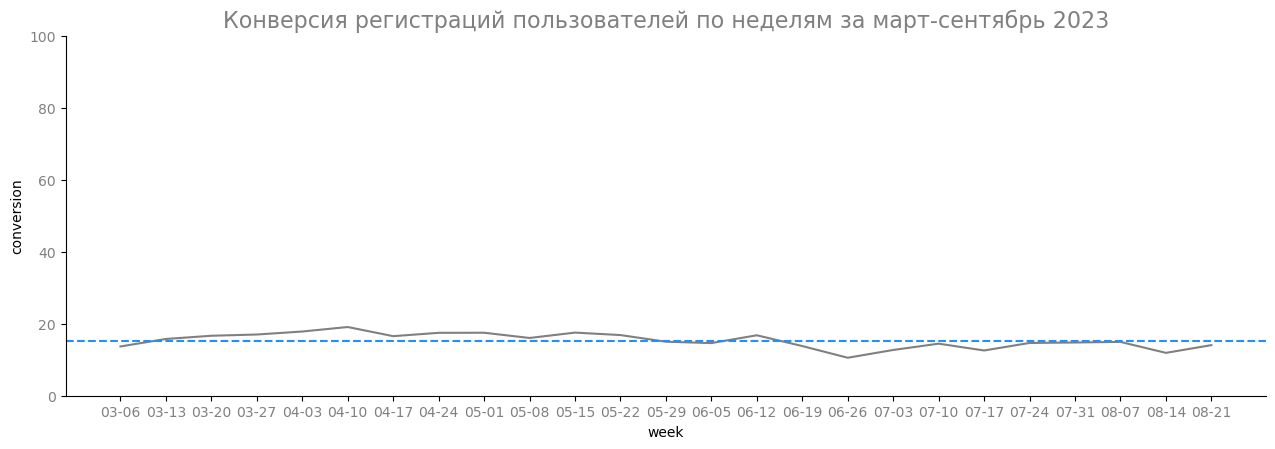

In [1490]:
plt.figure(figsize=(12, 4))
plt.ylim(0, 100)
plt.subplots_adjust(top=1, bottom=0.1, right=1.1, left=0.1, hspace=0.1, wspace=0.1)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(color='grey')
plt.yticks(color='grey')

plt.title(
    'Конверсия регистраций пользователей по неделям за март-сентябрь 2023',
    fontdict={'fontsize': 16,
              'color': 'grey'}
)

sns.lineplot(x='week', y='conversion', data=conversion_by_week, color='grey')
plt.axhline(y=conversion_by_week.conversion.mean(), color='dodgerblue', linestyle='--')


plt.savefig('./charts/conversion.png')


In [1491]:
conversion_by_week_platform.head()

,week,platform,visits,registrations,conversion
0,03-06,android,733,519,70.804911
1,03-06,ios,296,214,72.297297
2,03-06,web,7586,446,5.879251
3,03-13,android,562,450,80.071174
4,03-13,ios,199,147,73.869347


/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


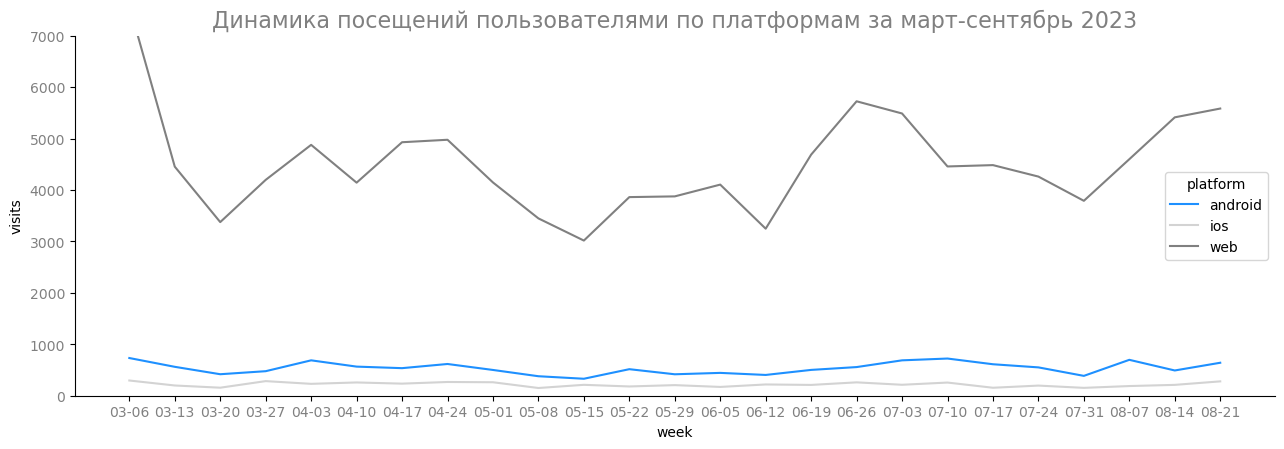

In [1492]:
color = ['dodgerblue', 'lightgrey', 'grey']

plt.figure(figsize=(12, 4))
plt.ylim(0, 7000)
plt.subplots_adjust(top=1, bottom=0.1, right=1.1, left=0.1, hspace=0.1, wspace=0.1)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(color='grey')
plt.yticks(color='grey')

plt.title(
    'Динамика посещений пользователями по платформам за март-сентябрь 2023',
    fontdict={'fontsize': 16,
              'color': 'grey'}
)

sns.lineplot(x='week', y='visits', data=conversion_by_week_platform, palette=color, hue='platform')


plt.savefig('./charts/visits_by_platform.png')

/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


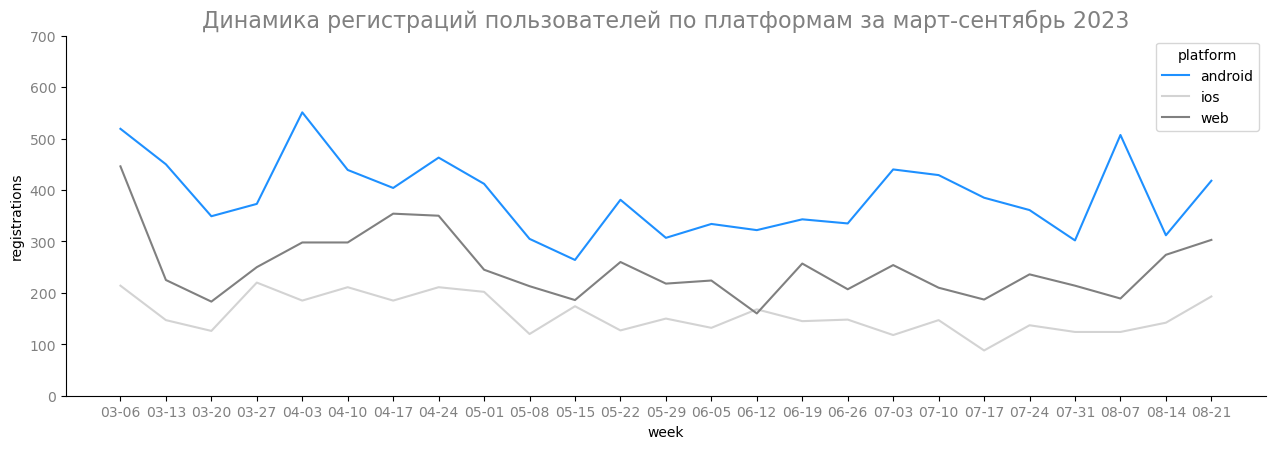

In [1493]:
color = ['dodgerblue', 'lightgrey', 'grey']

plt.figure(figsize=(12, 4))
plt.ylim(0, 700)
plt.subplots_adjust(top=1, bottom=0.1, right=1.1, left=0.1, hspace=0.1, wspace=0.1)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(color='grey')
plt.yticks(color='grey')

xlabel='week'
ylabel='registrations'

plt.title(
    'Динамика регистраций пользователей по платформам за март-сентябрь 2023',
    fontdict={'fontsize': 16,
              'color': 'grey'}
)

sns.lineplot(x='week', y='registrations', data=conversion_by_week_platform, palette=color, hue='platform')


plt.savefig('./charts/registrations_by_platform.png')

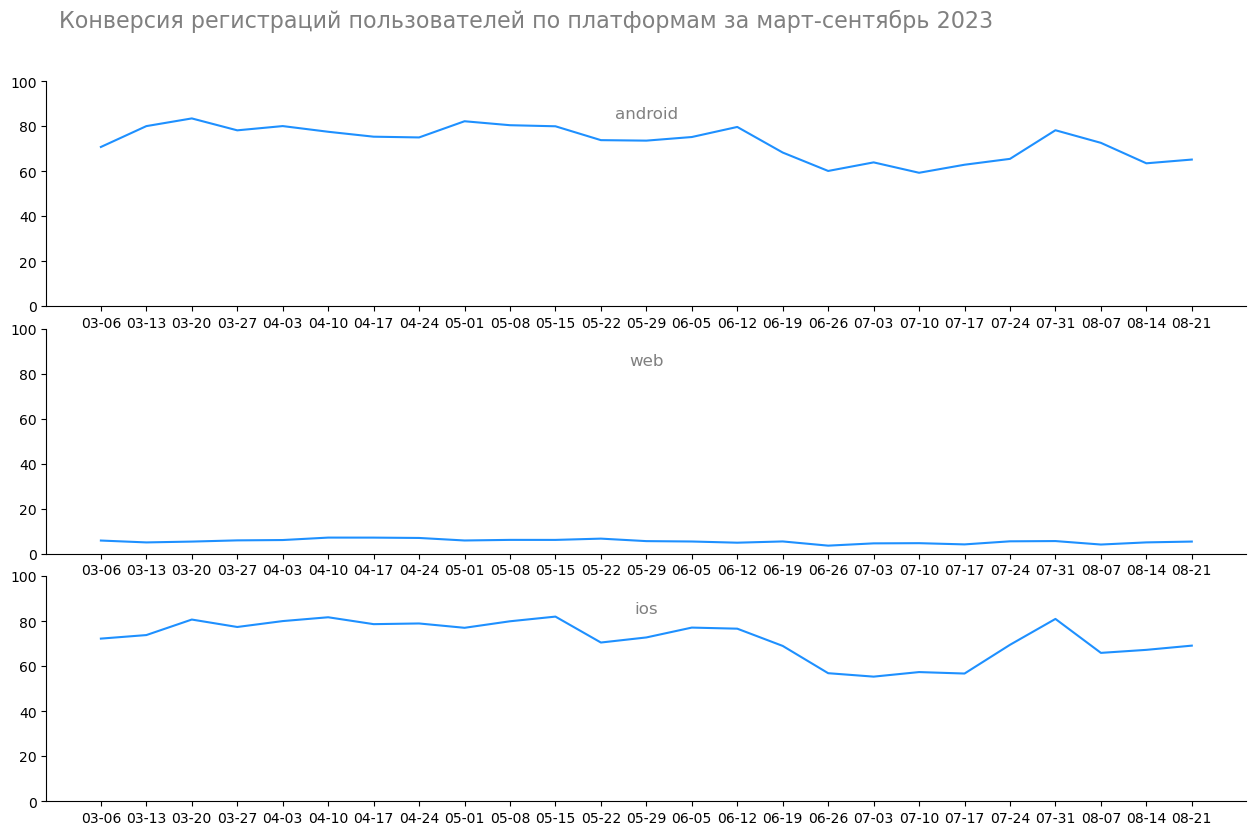

In [1494]:
color = ['dodgerblue', 'lightgrey', 'grey']

fig, ax = plt.subplots(3)
fig.set_size_inches(12, 9)

fig.suptitle('Конверсия регистраций пользователей по платформам за март-сентябрь 2023', 
             fontsize=16,
             color='grey'
            )

plt.subplots_adjust(top=0.9, bottom=0.1, right=1.1, left=0.1, hspace=0.1, wspace=0)


ax[0].plot(
    'week', 
    'conversion', 
    data=conversion_by_week_platform[conversion_by_week_platform.platform == 'android'],
    color='dodgerblue'
)
ax[0].set_title('android', color='grey', y=0.8)

ax[1].plot(
    'week', 
    'conversion', 
    data=conversion_by_week_platform[conversion_by_week_platform.platform == 'web'],
    color='dodgerblue'
)
ax[1].set_title('web', color='grey', y=0.8)
    
ax[2].plot(
    'week', 
    'conversion', 
    data=conversion_by_week_platform[conversion_by_week_platform.platform == 'ios'],
    color='dodgerblue'
)
ax[2].set_title('ios', color='grey', y=0.8)


for x in range(3):
    ax[x].set_ylim(0,100)
    ax[x].spines['right'].set_visible(False)
    ax[x].spines['top'].set_visible(False)
    
plt.savefig('./charts/conversion_by_platform.png')

In [1495]:
ads_conversion_short = ads_conversion[
    (ads_conversion.date_group > '2023-03-05') 
    & (ads_conversion.date_group < '2023-08-28')]

In [1496]:
ads_conversion_short['week'] = ads_conversion_short \
    .date_group.dt.to_period("W") \
    .astype('str').str.split('/') \
    .map(lambda x: x[0])

/var/folders/w6/n_fcyv095mx312wbmf2httjc0000gn/T/ipykernel_13152/3414577423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ads_conversion_short['week'] = ads_conversion_short \


In [1497]:
ads_conversion_short.week = pd.to_datetime(ads_conversion_short.week).dt.strftime('%m-%d')

/var/folders/w6/n_fcyv095mx312wbmf2httjc0000gn/T/ipykernel_13152/361896630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ads_conversion_short.week = pd.to_datetime(ads_conversion_short.week).dt.strftime('%m-%d')


In [1498]:
ads_conversion_by_week = ads_conversion_short \
    .groupby(['week'], as_index=False) \
    .agg({'visits': 'sum', 'registrations' : 'sum', 'cost': 'sum'})

In [1499]:
ads_conversion_by_week_campaign = ads_conversion_by_week = ads_conversion_short \
    .groupby(['week', 'utm_campaign'], as_index=False) \
    .agg({'visits': 'sum', 'registrations' : 'sum', 'cost': 'sum'})

In [1500]:
ads_conversion_by_week_campaign.head(25)

,week,utm_campaign,visits,registrations,cost
0,03-06,advanced_algorithms_series,8615,1179,1172.0
1,03-13,advanced_algorithms_series,3065,434,498.0
2,03-13,none,2150,388,0.0
3,03-20,none,2872,487,0.0
4,03-20,virtual_reality_workshop,1078,171,591.0
5,03-27,virtual_reality_workshop,4958,843,1287.0
6,04-03,virtual_reality_workshop,5797,1034,1587.0
7,04-10,virtual_reality_workshop,4967,948,1549.0
8,04-17,virtual_reality_workshop,5700,943,1350.0
9,04-24,virtual_reality_workshop,5861,1024,1270.0


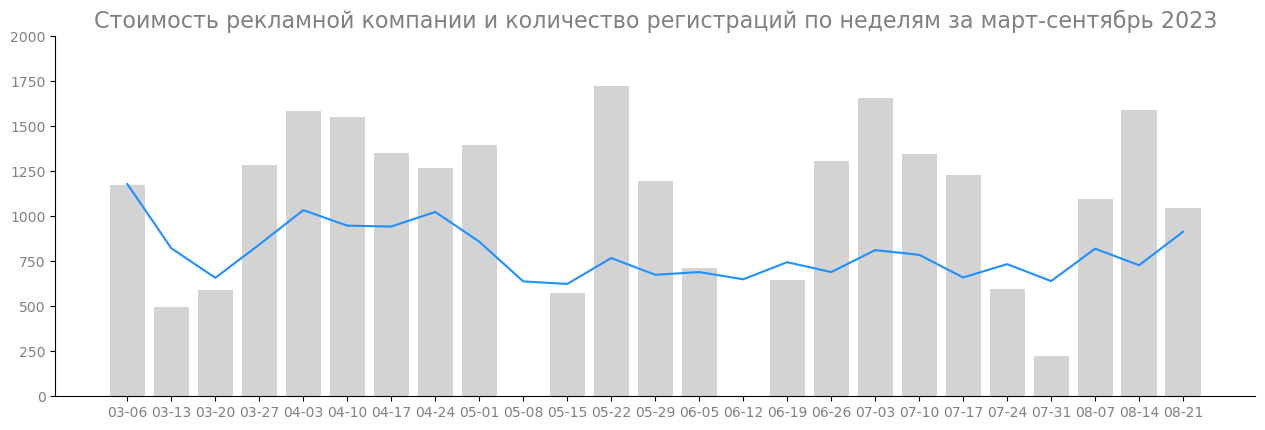

In [1501]:
plt.figure(figsize=(12, 4))
plt.ylim(0, 2000)
plt.subplots_adjust(top=1, bottom=0.1, right=1.1, left=0.1, hspace=0.1, wspace=0.1)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(color='grey')
plt.yticks(color='grey')

plt.title(
    'Стоимость рекламной компании и количество регистраций по неделям за март-сентябрь 2023',
    fontdict={'fontsize': 16,
              'color': 'grey'}
)

plt.bar('week', 'cost', data=ads_conversion_by_week, color='lightgrey')
plt.plot('week', 'registrations', data=conversion_by_week, color='dodgerblue')

plt.savefig('./charts/registrations_by_ads_cost.png')


In [1502]:
ads_conversion.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,212.0,advanced_algorithms_series
1,2023-03-02,613,105,252.0,advanced_algorithms_series
2,2023-03-03,683,107,202.0,advanced_algorithms_series
3,2023-03-04,647,158,223.0,advanced_algorithms_series
4,2023-03-05,707,115,265.0,advanced_algorithms_series


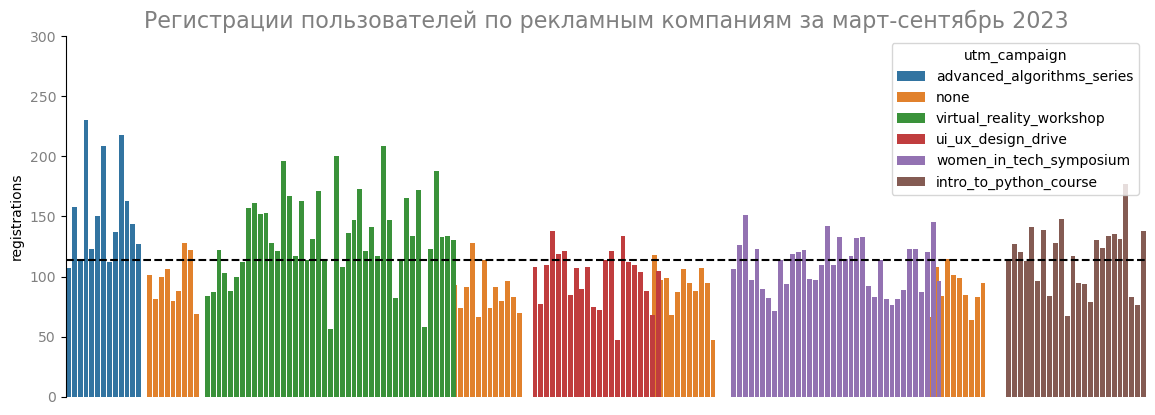

In [1503]:
plt.figure(figsize=(12, 4))
plt.ylim(0, 300)
plt.subplots_adjust(top=1, bottom=0.1, right=1, left=0.1, hspace=0.1, wspace=0.1)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.yticks(color='grey')
plt.gca().axes.xaxis.set_visible(False)
plt.title(
    'Регистрации пользователей по рекламным компаниям за март-сентябрь 2023',
    fontdict={'fontsize': 16,
              'color': 'grey'}
)

sns.barplot(x='date_group', 
            y='registrations', 
            data=ads_conversion, 
            width=5,
            hue='utm_campaign')
plt.axhline(y=ads_conversion.registrations.mean(), color='black', linestyle='--')


plt.savefig('./charts/registrations_by_campaign.png')


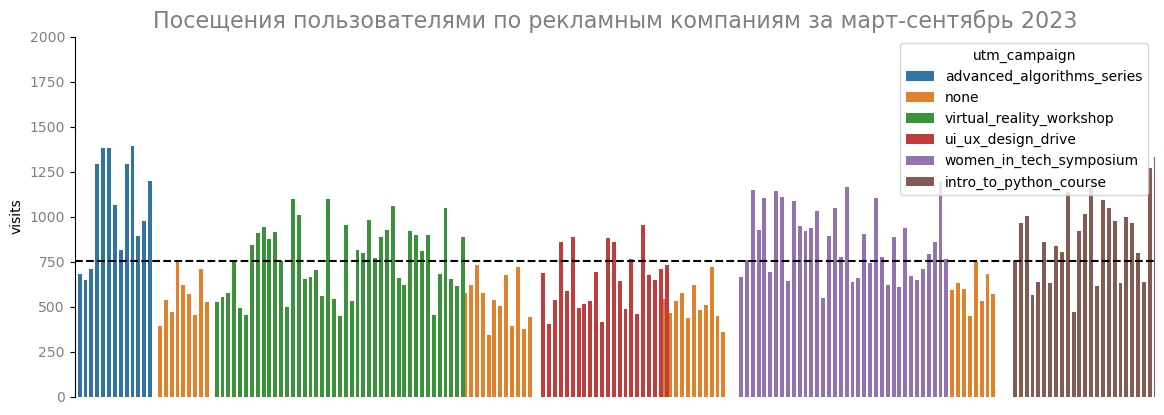

In [1504]:
plt.figure(figsize=(12, 4))
plt.ylim(0, 2000)
plt.subplots_adjust(top=1, bottom=0.1, right=1, left=0.1, hspace=0.1, wspace=0.1)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().axes.xaxis.set_visible(False)
plt.yticks(color='grey')

plt.title(
    'Посещения пользователями по рекламным компаниям за март-сентябрь 2023',
    fontdict={'fontsize': 16,
              'color': 'grey'}
)

sns.barplot(x='date_group', 
            y='visits', 
            data=ads_conversion, 
            width=4,
            hue='utm_campaign')
plt.axhline(y=ads_conversion.visits.mean(), color='black', linestyle='--')

plt.savefig('./charts/visits_by_campaign.png')